In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import pandas as pd
import re
import shutil
from sklearn.model_selection import StratifiedKFold
import random
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize'] = (20,10)
font = {'family' : 'DejaVu Sans',  'weight' : 'normal',  'size'  : 20}
plt.rc('font', **font)

In [4]:
HOME_FOLDER = '/media/scratch/astamoulakatos/centre_Ch2/'

noOfFiles = 0
noOfDir = 0

In [5]:
for base, dirs, files in os.walk(HOME_FOLDER):
    print('Looking in : ',base)
    for directories in dirs:
        noOfDir += 1
    for Files in files:
        noOfFiles += 1

Looking in :  /media/scratch/astamoulakatos/centre_Ch2/
Looking in :  /media/scratch/astamoulakatos/centre_Ch2/bur
Looking in :  /media/scratch/astamoulakatos/centre_Ch2/bur/Survey-2-2012__Project 1__IC2__KP155.800-186.495_D__DATA_20120927225819562__20120927225820031@DVR-1_Ch2__1417734
Looking in :  /media/scratch/astamoulakatos/centre_Ch2/bur/Survey-2-2012__Project 1__IC2__KP155.800-186.495_D__DATA_20120927053113750__20120927053114813@DVR-1_Ch2__263699
Looking in :  /media/scratch/astamoulakatos/centre_Ch2/bur/Survey-2-2012__Project 1__IC2__KP130.417-145.077_A__DATA_20120923130505000__20120923130505812@DVR-1_Ch2__761529
Looking in :  /media/scratch/astamoulakatos/centre_Ch2/bur/Survey-2-2012__Project 1__IC2__KP155.800-186.495_D__DATA_20120927094434797__20120927094436703@DVR-1_Ch2__841853
Looking in :  /media/scratch/astamoulakatos/centre_Ch2/bur/Survey-2-2012__Project 1__IC2__KP130.417-145.077_A__DATA_20120923170028719__20120923170030282@DVR-1_Ch2__1522022
Looking in :  /media/scratch

In [6]:
print('Number of files',noOfFiles)
print('Number of Directories',noOfDir)
print('Total:',(noOfDir + noOfFiles))

Number of files 549599
Number of Directories 2058
Total: 551657


In [7]:
number_of_frames = []
event_path = []
for d in os.listdir(HOME_FOLDER):
    label_path = os.path.join(HOME_FOLDER,d)
    for l in os.listdir(label_path):
        file_path = os.path.join(label_path,l)
        #print(len(os.listdir(file_path)), file_path)
        number = len(os.listdir(file_path))
        number_of_frames.append(number) 
#         if number > 400:
#             shutil.rmtree(file_path)
#         else:
#             number_of_frames.append(number)                          
        event_path.append(file_path)

In [8]:
df = pd.DataFrame(columns = ['event_path', 'number_of_frames'])

In [9]:
df.event_path = event_path
df.number_of_frames = number_of_frames

In [10]:
df

,event_path,number_of_frames
0,/media/scratch/astamoulakatos/centre_Ch2/bur/S...,400
1,/media/scratch/astamoulakatos/centre_Ch2/bur/S...,400
2,/media/scratch/astamoulakatos/centre_Ch2/bur/S...,102
3,/media/scratch/astamoulakatos/centre_Ch2/bur/S...,400
4,/media/scratch/astamoulakatos/centre_Ch2/bur/S...,175
...,...,...
2048,/media/scratch/astamoulakatos/centre_Ch2/exp_a...,181
2049,/media/scratch/astamoulakatos/centre_Ch2/exp_a...,146
2050,/media/scratch/astamoulakatos/centre_Ch2/exp_a...,98
2051,/media/scratch/astamoulakatos/centre_Ch2/exp_a...,90


In [11]:
df.number_of_frames.max()

400

In [21]:
df.number_of_frames.min()

1

In [12]:
df.number_of_frames.mean()

267.70530930345836

In [13]:
df['exposure'] = 0
df['burial'] = 0
df['field_joint'] = 0
df['anode'] = 0
df['free_span'] = 0

In [14]:
labels = []
for i in range(len(df)):
    m = re.search('Ch2/(.+?)/S', str(df.event_path[i]))
    #m = re.search('egs/(.+?)/S', str(df.event_path[i]))
    boom = m.group(1)
    if boom == 'exp_and':
        df.exposure[i] = 1
        df.anode[i] = 1
    if boom == 'exp':
        df.exposure[i] = 1
    if boom == 'bur':
        df.burial[i] = 1
    if boom == 'exp_fs':
        df.exposure[i] = 1
        df.free_span[i] = 1
    if boom == 'exp_fj':
        df.exposure[i] = 1
        df.field_joint[i] = 1
    labels.append(boom)

/home/astamoulakatos/.conda/envs/deep/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/astamoulakatos/.conda/envs/deep/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/astamoulakatos/.conda/envs/deep/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fr

In [15]:
df['label'] = labels

In [24]:
df1 = df[['event_path','exposure','burial','field_joint','anode','free_span']]

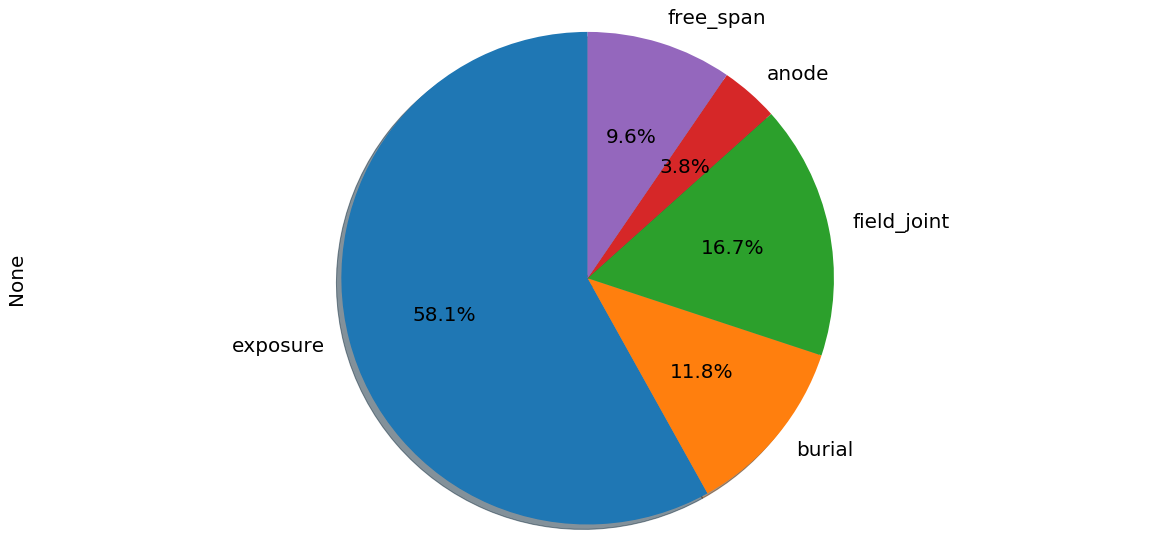

In [25]:
fig1, ax1 = plt.subplots()
df1.iloc[:,1:].sum(axis=0).plot.pie(autopct='%1.1f%%',shadow=True, startangle=90,ax=ax1)
ax1.axis("equal")
plt.show()

# events

In [26]:
df1.iloc[:,1:].sum(axis=0)

exposure       1659
burial          338
field_joint     477
anode           109
free_span       273
dtype: int64

# frames

In [27]:
df.groupby('label')['number_of_frames'].sum()

label
bur        112977
exp        298928
exp_and     11434
exp_fj      52485
exp_fs      72254
Name: number_of_frames, dtype: int64

# exclude events with less than 50 frames (2 secs)

In [22]:
df.number_of_frames.min()

1

In [23]:
df = df[df.number_of_frames>=50]
df = df[df.number_of_frames<=400]

# less exposure

In [38]:
df_exp = df[df.label=='exp']

In [39]:
df_exp = df_exp.sample(frac=0.3)

In [40]:
df_exp

,event_path,number_of_frames,exposure,burial,field_joint,anode,free_span,label
1400,/media/scratch/astamoulakatos/centre_Ch2/exp/S...,400,1,0,0,0,0,exp
1224,/media/scratch/astamoulakatos/centre_Ch2/exp/S...,400,1,0,0,0,0,exp
679,/media/scratch/astamoulakatos/centre_Ch2/exp/S...,400,1,0,0,0,0,exp
671,/media/scratch/astamoulakatos/centre_Ch2/exp/S...,400,1,0,0,0,0,exp
673,/media/scratch/astamoulakatos/centre_Ch2/exp/S...,398,1,0,0,0,0,exp
...,...,...,...,...,...,...,...,...
1447,/media/scratch/astamoulakatos/centre_Ch2/exp/S...,400,1,0,0,0,0,exp
1159,/media/scratch/astamoulakatos/centre_Ch2/exp/S...,400,1,0,0,0,0,exp
1148,/media/scratch/astamoulakatos/centre_Ch2/exp/S...,67,1,0,0,0,0,exp
985,/media/scratch/astamoulakatos/centre_Ch2/exp/S...,290,1,0,0,0,0,exp


In [41]:
df_exp.number_of_frames.mean()

376.12916666666666

In [42]:
df_new = df[df.label!='exp']

In [43]:
df_final = pd.concat([df_new, df_exp])

In [48]:
df_final.reset_index(drop=True)

,event_path,number_of_frames,exposure,burial,field_joint,anode,free_span,label
0,/media/scratch/astamoulakatos/centre_Ch2/bur/S...,400,0,1,0,0,0,bur
1,/media/scratch/astamoulakatos/centre_Ch2/bur/S...,400,0,1,0,0,0,bur
2,/media/scratch/astamoulakatos/centre_Ch2/bur/S...,102,0,1,0,0,0,bur
3,/media/scratch/astamoulakatos/centre_Ch2/bur/S...,400,0,1,0,0,0,bur
4,/media/scratch/astamoulakatos/centre_Ch2/bur/S...,175,0,1,0,0,0,bur
...,...,...,...,...,...,...,...,...
1432,/media/scratch/astamoulakatos/centre_Ch2/exp/S...,400,1,0,0,0,0,exp
1433,/media/scratch/astamoulakatos/centre_Ch2/exp/S...,400,1,0,0,0,0,exp
1434,/media/scratch/astamoulakatos/centre_Ch2/exp/S...,67,1,0,0,0,0,exp
1435,/media/scratch/astamoulakatos/centre_Ch2/exp/S...,290,1,0,0,0,0,exp


In [49]:
df_final.label.value_counts()

exp_fj     477
bur        338
exp_fs     273
exp        240
exp_and    109
Name: label, dtype: int64

In [50]:
df1 = df_final[['event_path','exposure','burial','field_joint','anode','free_span']]

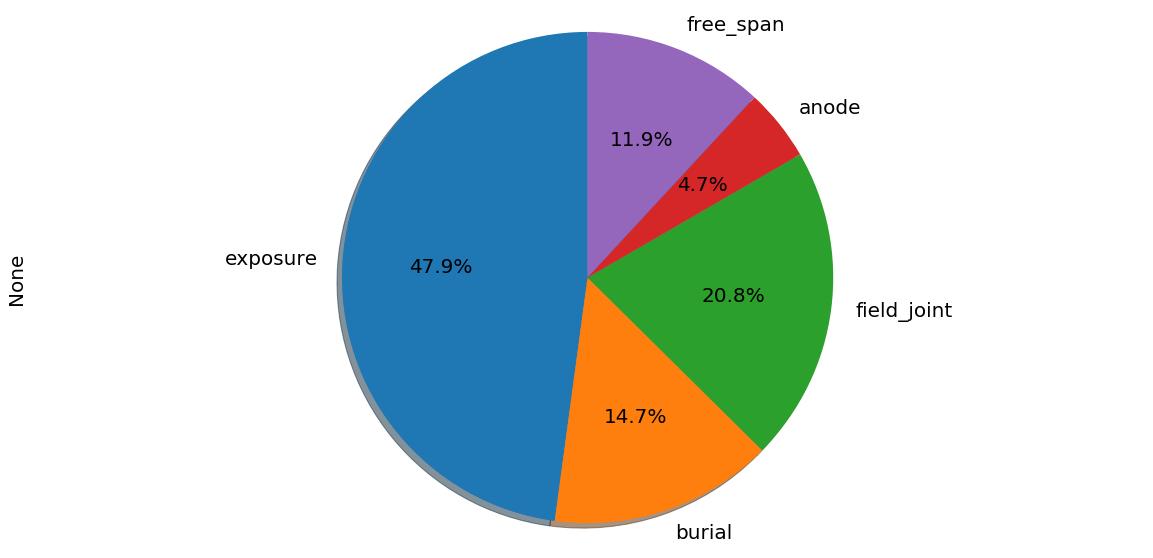

In [51]:
fig1, ax1 = plt.subplots()
df1.iloc[:,1:].sum(axis=0).plot.pie(autopct='%1.1f%%',shadow=True, startangle=90,ax=ax1)
ax1.axis("equal")
plt.show()

In [52]:
df_final.to_csv('../important_csvs/more_balanced_dataset/events_with_number_of_frames_less_exp.csv', index=False)